# Mid category detection_using_New_Algo_3_final

### The essence of Algo 2 is followed except that the hulls with area less than a particular value are weeded out (without repeating DB Scan operation). This is quite effective in removing small hulls


1) The grayscale image - Gaussian Filter - Local Thresholding - Rescaling of Intensity (Intensity stretching) <BR>
2) A Histogram-based threshold, known as Ridler-Calvard method results in intensities that separate the image into two groups of pixels, where the threshold intensity is midway between the mean intensities of these groups. <br>
3) Morphological operations - removing of islands of noise, removing of holes in objects <br>
4) DB Scan is done to cluster the image into different groups <br>
5) The groups and their coordinates with small areas are discarded, and the ones exceeding a particular area are re-organized into new groups, and new coordinates (DB Scan process is not repeated) <br>
6) GroupVertices are generated for each of the new group and the different groups are marked using Convex hulls<br>
7) The GroupVertices are used to define a bounding box (rectangle) and a minimum bounding rectangle (rotated rectangle)

##### The tunable parameters that are there in this algorithm are:

sigma - standard deviation of the gaussian filter <br>
bloc_size - neighbourhood size of the local thresholding<br>
min_size - the minimum size below which the small objects are removed<br>
eps - for the DBSCAN clustering, specifies how close two points should be to be considered part of a cluster<br>
percentile - (not used as it throws up errors when no detection is possible)<br><br>

The minimum hull area - used as a threshold is preset to be 400

#### Sometimes the DB Scan fails to cluster at all in which case the output is the same image as the input without any annotations.<br>

#### The scenario in which the detection is not so accurate - mostly arises from the lack of poor contrast (locally) between foreground and background

In [169]:
#First idea that's being tested out - Hull Area and Hull Volume - checked out and documented to some extent

In [50]:
import cv2

In [51]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib import path


import pandas as pd



from skimage import io
from skimage import transform
#from skimage import segmentation
from skimage import filters
#from skimage import morphology
from skimage import measure
from skimage import util

from sklearn import cluster

from scipy.spatial import ConvexHull

In [52]:
from ipywidgets import interactive
import ipywidgets as widgets

import numpy as np
from matplotlib import pyplot as plt

from skimage import io
from skimage import util
from skimage import filters
from skimage import morphology
from skimage import measure
from skimage import exposure

from sklearn import cluster

import os

In [53]:
farmWidth = 3.0 # meters
tubenetPerMeter = 10 # meters
scale = 1.0

initSigma = 1
offset = -0.05
finalSigma = 1
min_samples = 5

sigma=1.0
block_size=41
min_size=128
eps=10
percentile_range = [80,100]

In [54]:
def read(imgFile,invert=False):
    img = io.imread(imgFile,as_gray=True)
    img = util.img_as_float(img)
    if invert:
        img = util.invert(img)    
    
    img_x, img_y = img.shape
    return img

def readRGB(imgFile):
    rgbimg = io.imread(imgFile)
    return rgbimg

def rescale(img,scale):
    if img is not None:
        scale = np.float(scale)
        img_rs = transform.rescale(img,scale,multichannel=False)
        return img_rs
    
def plotImg(img,title=None,cmap='gray',figsize=(15,15)):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.axis('off')
    ax.imshow(img,cmap=cmap)
    if title:
        ax.set_title(title,fontsize=20)
    plt.show()
    
    
def init_thresh(img):
    img_g = filters.gaussian(img,sigma=sigma)

    img_g_thresh = filters.threshold_local(img_g,block_size=block_size)

    img_g_applyThresh = (img_g-img_g_thresh)

    img_g_applyThresh = exposure.rescale_intensity(img_g_applyThresh)
    
    return(img_g_applyThresh)

def apply_iso(img_g_applyThresh):

    img_g_applyThresh_iso = filters.threshold_isodata(img_g_applyThresh)
    img_areas = (img_g_applyThresh<img_g_applyThresh_iso)
    
    return(img_areas)

def apply_clrclo(img_areas, min_size):
    img_clr = morphology.remove_small_objects(img_areas,min_size=min_size,connectivity=2)
    img_clo = morphology.remove_small_holes(img_clr,area_threshold=2048,connectivity=2)
    coords = np.asarray(np.where(img_clo == True)).T
    return(coords)

def applyDBSCAN(coords,eps=10, min_samples=5):
    dbscan = cluster.DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(coords)
    predictions = dbscan.labels_
    return predictions



def applyConvexHull_Groups(coords,groups):
    
    groupNums_overall = np.unique(groups)
    groupNums_subset = []
    
    groupCoords = []
    groupHulls = []
    #img_rs_groups = []
    groupVertices = []
    #groupAreas = [ ]
    #groupVolumes = [ ]
    
    for groupNum in groupNums_overall:
        
        thisCoords = []
        
        for i in range(len(coords)):
            if groups[i]==groupNum:
                thisCoords.append(coords[i])
        
        
        thisHull = ConvexHull(thisCoords)
        hull_area = thisHull.area
        
        if hull_area>=400:
            groupNums_subset.append(groupNum)
            groupCoords.append(np.array(thisCoords))
            groupHulls.append(thisHull)
            #groupAreas.append(thisHull.area)
            #groupVolumes.append(thisHull.volume)

            #thisImg = np.multiply(img, img_groups==groupNum)
            #img_rs_groups.append(thisImg)
        
            thisVertices = []
            for vertex in thisHull.vertices:
                thisVertices.append([thisCoords[vertex][1],thisCoords[vertex][0]])
            groupVertices.append(np.array(thisVertices))

    return groupCoords,groupHulls,groupVertices,groupNums_subset





def applyLabels_binImg(img,coords,labels):
    label_mask = np.zeros(img.shape).astype('uint')
    for i in range(len(coords)):
        row,col = coords[i]
        label_mask[row][col]=labels[i]
    return label_mask


def small_weeding(groupLabel_Mask):
    group_areas = [region.area for region in measure.regionprops(groupLabel_Mask)]
    new_coords = []
    new_groups = []
    
    #percentile_range = [80,100]
    
    #size_min = np.percentile(group_areas,percentile_range[0])
    #size_max = np.percentile(group_areas,percentile_range[1])

    #img_groupMask = np.zeros(img.shape).astype('float')
    #img_new_labelMask = np.zeros(img.shape).astype('uint')
    


    for region in measure.regionprops(groupLabel_Mask):
        if region.area>=400:        
            reg_coords = region.coords
            for elem1, elem2 in reg_coords:
                #img_groupMask[elem1, elem2] = True
                #img_new_labelMask[elem1, elem2] = groupLabel_Mask[elem1, elem2]
                new_coords.append([elem1, elem2])
                new_groups.append(groupLabel_Mask[elem1, elem2])
    
    new_coords = np.asarray(new_coords)
    new_groups = np.asarray(new_groups)
    
    return(new_coords, new_groups)

In [55]:
def plotRGBImg_GroupsRS(rgbimg,groupNums,groupVertices,scale, index_ext, fmt='k-',linewidth=1,annotate=True):
    fig, ax = plt.subplots(1,1,figsize=(15, 15))
    ax.axis('off')
    ax.imshow(rgbimg)
    for i,groupNum in enumerate(groupNums):
        ax.fill(groupVertices[i][:,0]/scale,
                groupVertices[i][:,1]/scale,
                fmt,linewidth=linewidth,fill=False)
        
        
        length = groupVertices[i].shape[0]
        sum_x = np.sum(groupVertices[i][:, 0])
        sum_y = np.sum(groupVertices[i][:, 1])
        
        if annotate:
            ax.annotate(int(i+1),xy=(sum_x/(length*scale), (sum_y)/(length * scale)), color='gold', size = 13)
        
    filename = 'hull'+str(index_ext)+'.png'
    path = '/Users/praneeth/Downloads/Image Processing/Srideep_to_Praneeth_files/Bigger_basket/hull/'+filename
    plt.savefig(path)
    


def plotRGBImg_GroupsRS_rectangle(rgbimg,groupNums,groupVertices,scale, index_ext, fmt='k-',linewidth=1,annotate=True):
    color = (0, 0, 0)
    thickness = 2
    
    for i,groupNum in enumerate(groupNums):
        x,y,w,h = cv2.boundingRect(groupVertices[i])        
        rgbimg = cv2.rectangle(rgbimg,(x,y),(x+w,y+h),color,thickness)
     
    fig, ax = plt.subplots(1,1,figsize=(15, 15))
    ax.axis('off')
    ax.imshow(rgbimg)

    for i in range(len(groupNums)):
        x,y,w,h = cv2.boundingRect(groupVertices[i])        
        if annotate:
            ax.annotate(int(i+1),xy=(int(x + (w/4)), int(y + (h/2))),  color='gold', size = 13)
    
    filename = 'rectangle'+str(index_ext)+'.png'
    path = '/Users/praneeth/Downloads/Image Processing/Srideep_to_Praneeth_files/Bigger_basket/rectangle/'+filename
    plt.savefig(path)


    
def plotRGBImg_GroupsRS_rotated_rectangle(rgbimg,groupNums,groupVertices, scale, index_ext, fmt='k-',linewidth=1, annotate=True):
    
    #rotated_rect_coordinates = []
    #rotated_rect_areas =[]
    
    color = (0,0,0) 
    thickness = 2
    isClosed = True

    for i,groupNum in enumerate(groupNums):
                
        rect = cv2.minAreaRect(groupVertices[i])
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        rgbimg = cv2.drawContours(rgbimg,[box],0,color,thickness)

        #rotated_rect_area_specific = rect[1][0] * rect[1][1]
        #rotated_rect_areas.append(rotated_rect_area_specific)
        #rotated_rect_coordinates.append([box])

    fig, ax = plt.subplots(1,1,figsize=(15, 15))
    ax.axis('off')
    ax.imshow(rgbimg)


    for i in range(len(groupNums)):
        length = groupVertices[i].shape[0]
        sum_x = np.sum(groupVertices[i][:, 0])
        sum_y = np.sum(groupVertices[i][:, 1])

        if annotate:
            ax.annotate(int(i+1),xy=(sum_x/(length*scale), sum_y/(length * scale)), color='gold', size = 13)

    filename = 'rotated_rectangle'+str(index_ext)+'.png'
    path = '/Users/praneeth/Downloads/Image Processing/Srideep_to_Praneeth_files/Bigger_basket/rotated_rectangle/'+filename
    plt.savefig(path)



In [56]:
folder = '/Users/praneeth/Downloads/Image Processing/Srideep_to_Praneeth_files/Bigger_basket/images_from_video'

In [57]:
list_of_files = [
 'DRONE_TRANSECT_AR_16SEP19 09.png',
 'DRONE_TRANSECT_AR_16SEP19 10.png',
 'DRONE_TRANSECT_AR_16SEP19 11.png',
 'DRONE_TRANSECT_AR_16SEP19 12.png',
 'DRONE_TRANSECT_AR_16SEP19 13.png',
 'DRONE_TRANSECT_AR_16SEP19 14.png',
 'DRONE_TRANSECT_AR_16SEP19 15.png',
 'DRONE_TRANSECT_AR_16SEP19 16.png',
 'DRONE_TRANSECT_AR_16SEP19 17.png',
 'DRONE_TRANSECT_AR_16SEP19 18.png',
 'DRONE_TRANSECT_AR_16SEP19 19.png',
 'DRONE_TRANSECT_AR_16SEP19 20.png',
 'DRONE_TRANSECT_AR_16SEP19 21.png',
 'DRONE_TRANSECT_AR_16SEP19 22.png',
 'DRONE_TRANSECT_AR_16SEP19 23.png',
 'DRONE_TRANSECT_AR_16SEP19 24.png',
 'DRONE_TRANSECT_AR_16SEP19 25.png',
 'DRONE_TRANSECT_AR_16SEP19 26.png',
 'DRONE_TRANSECT_AR_16SEP19 27.png',
 'DRONE_TRANSECT_AR_16SEP19 28.png',
 'DRONE_TRANSECT_AR_16SEP19 29.png',
 'DRONE_TRANSECT_AR_16SEP19 30.png',
 'DRONE_TRANSECT_AR_16SEP19 31.png',
 'DRONE_TRANSECT_AR_16SEP19 32.png',
 'DRONE_TRANSECT_AR_16SEP19 33.png',
 'DRONE_TRANSECT_AR_16SEP19 34.png',
 'DRONE_TRANSECT_AR_16SEP19 35.png',
 'DRONE_TRANSECT_AR_16SEP19 36.png',
 'DRONE_TRANSECT_AR_16SEP19 37.png',
 'DRONE_TRANSECT_AR_16SEP19 38.png',
 'DRONE_TRANSECT_AR_16SEP19 39.png',
 'DRONE_TRANSECT_AR_16SEP19 40.png',
 'DRONE_TRANSECT_AR_16SEP19 41.png',
 'DRONE_TRANSECT_AR_16SEP19 42.png',
 'DRONE_TRANSECT_AR_16SEP19 43.png',
 'scene01051.png',
 'scene01501.png',
 'scene04051.png',
 'scene08251.png',
 'scene08701.png']

In [58]:
list_of_files = [
 'DRONE_TRANSECT_AR_16SEP19 09.png']

In [59]:
index = 1

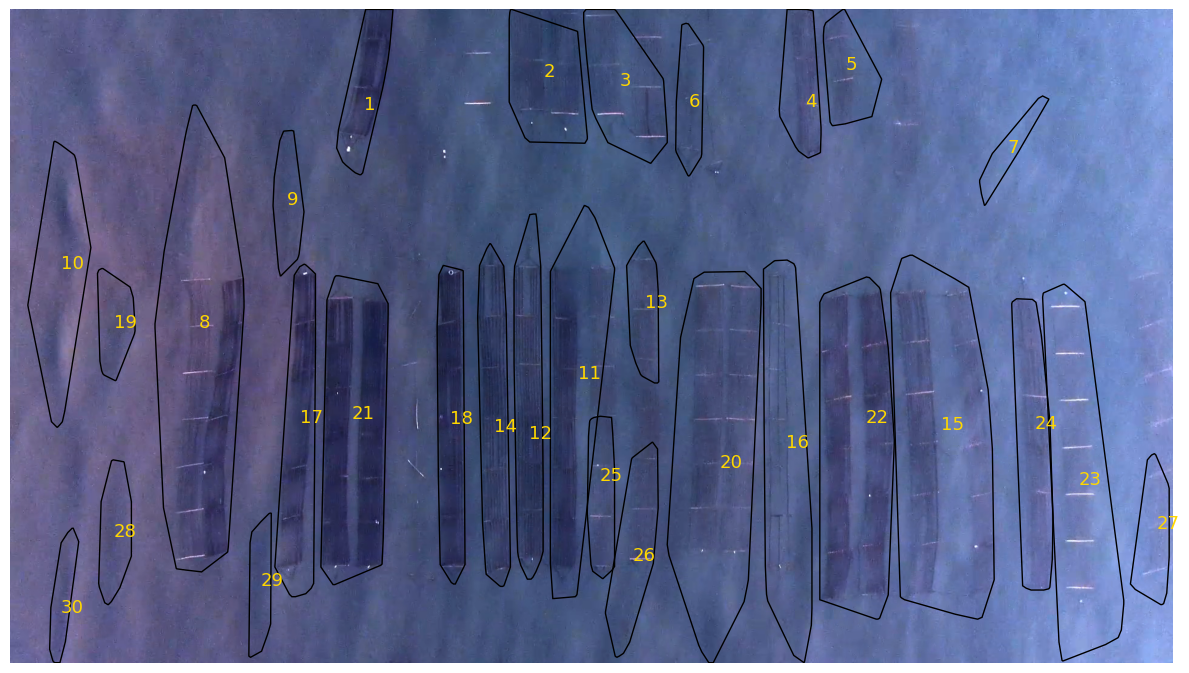

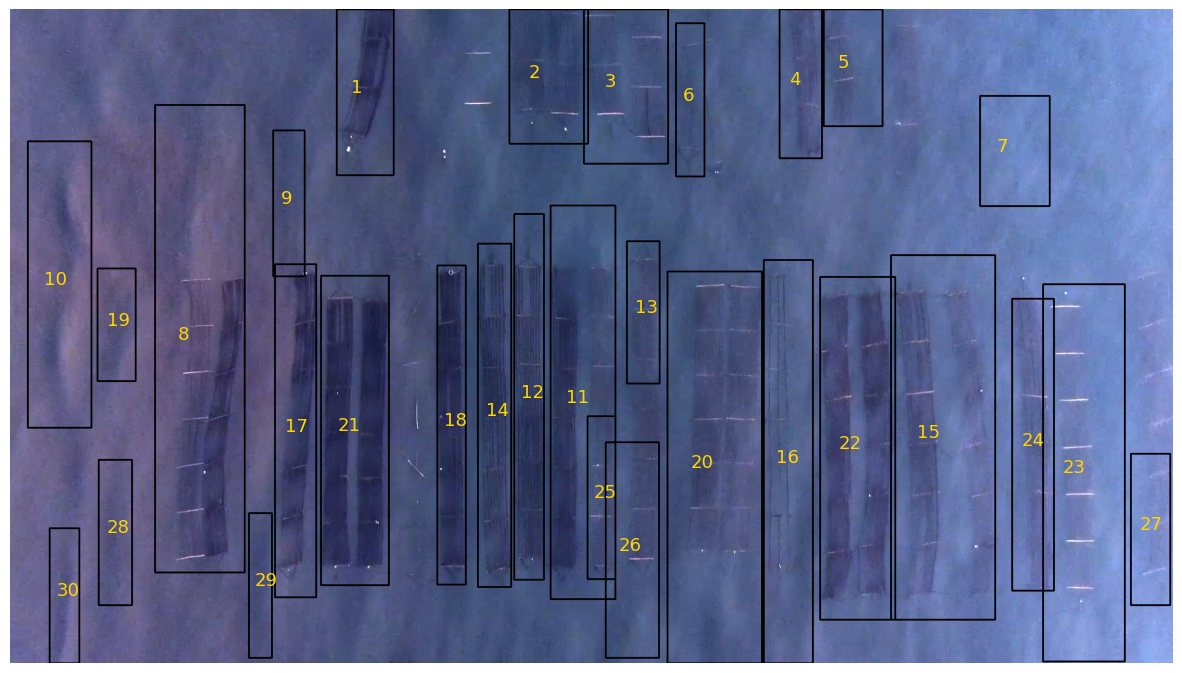

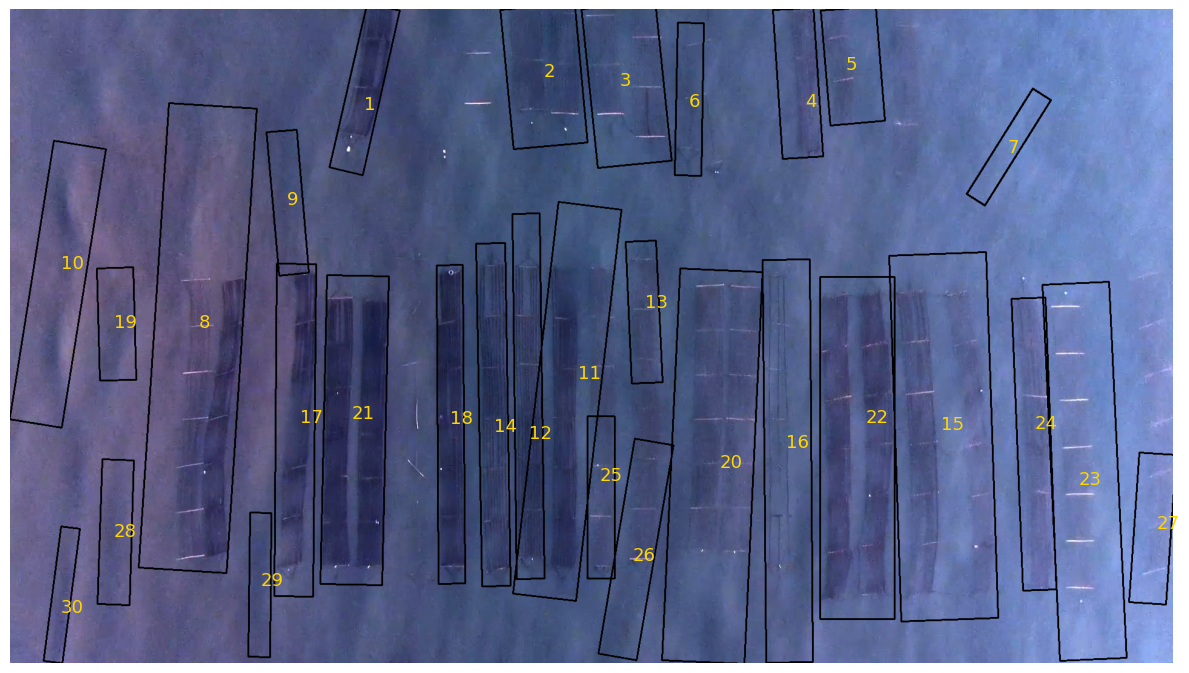

In [60]:
for filename in list_of_files:
    index = index + 1
    imgFile = os.path.join(folder,filename)
    img = read(imgFile)
    imgrgb = readRGB(imgFile)
    
    img_g_applyThresh = init_thresh(img)
    img_areas = apply_iso(img_g_applyThresh)
    coords = apply_clrclo(img_areas, min_size)
    groups = applyDBSCAN(coords, eps=eps, min_samples=min_samples)
    groupLabel_Mask = applyLabels_binImg(img,coords,groups)
    new_coords,new_groups = small_weeding(groupLabel_Mask)
    groupCoords,groupHulls,groupVertices, groupNums_subset = applyConvexHull_Groups(new_coords,new_groups)
    groupNums = np.asarray(groupNums_subset, 'uint64')
    
    imgrgb_hull = imgrgb.copy()
    imgrgb_rect = imgrgb.copy()
    imgrgb_rot_rect= imgrgb.copy()
    
    plotRGBImg_GroupsRS(imgrgb_hull,groupNums,groupVertices,scale, index, annotate=True)
    plotRGBImg_GroupsRS_rectangle(imgrgb_rect,groupNums,groupVertices,scale, index, annotate=True)
    plotRGBImg_GroupsRS_rotated_rectangle(imgrgb_rot_rect,groupNums,groupVertices, scale, index, annotate=True)